<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install mpi4py

     |████████████████████████████████| 2.5 MB 13.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.2-cp37-cp37m-linux_x86_64.whl size=2183218 sha256=86f5a13dc4115d2937d3feace04766b43fd6668a3f319a0b9e124e195b54dce8
  Stored in directory: /root/.cache/pip/wheels/62/d6/0a/91ea5f998589bc72ca3fcf425c0e364baf8536753e1cd26ea4
Successfully built mpi4py


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from integral import integrate, f, g

from mpi4py import MPI
# Wider cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Make sure folder for images exist
import os
try:
    os.mkdir('imgs/')
except FileExistsError as err:
    pass

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


$S = \displaystyle \int_a^b \displaystyle x^4 \, dx$ , where $a = -3$ and $b = 3$

1. Provide a parallel numerical computation of the integral $S$ using, for example, the trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$

Analytical expression
$S = \frac{x^5}{5} |_a^b$

In [5]:
D_range = np.linspace(10, 10000, num=1000)
limits = [-3, 3]
S = g(limits[1]) - g(limits[0]) # exact value
err = []
for D in D_range:
    dd = int(D)
    S_d = integrate(f, limits=limits, num_steps=dd)
    err.append(S - S_d)

In [6]:
S_d

97.19030591676032

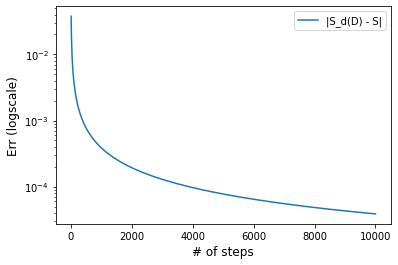

In [ ]:
plt.semilogy(D_range, err, label="|S_d(D) - S|")   
plt.xlabel("# of steps", fontsize=12)
plt.ylabel("Err (logscale)", fontsize=12)
plt.legend()

#Parallel part

In [ ]:
times = []
for i in range(1, 8):
    time_parallel = %timeit -o -q ! mpirun --allow-run-as-root -n {i} python integral.py -parallel 1
    #time_seq = %timeit -o -q !python integral.py #-parallel 0
    av_parallel = sum(time_parallel.all_runs)/len(time_parallel.all_runs)
    #av_seq = sum(time_seq.all_runs)/len(time_seq.all_runs)
    times.append(av_parallel)
    print(f"i: {i}, parallel: {av_parallel}")#print(f"i: {i}, parallel: {av_parallel}, seq: {av_seq}")

i: 1, parallel: 1.4411289681999733
i: 2, parallel: 2.1016683897999426
i: 3, parallel: 3.0270393686000263
i: 4, parallel: 3.868986245200085
i: 5, parallel: 4.751365291999991
i: 6, parallel: 5.537750033599923
i: 7, parallel: 6.418287874199995


Text(0.5, 0.98, 'Speedup vs Np')

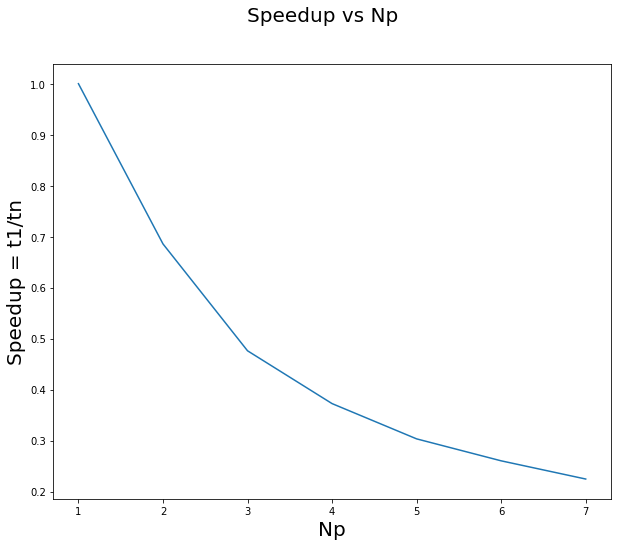

In [ ]:
#speedup = [x / y for x,y in times]
#plt.plot(speedup)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

t1 = times[0]
def SpeedUp(tn):
    return t1/tn
Speedup = list(map(SpeedUp, times))
plt.figure(figsize=(10, 8))
num_of_processes = np.linspace(1, len(times), len(times))
plt.plot(num_of_processes, Speedup)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)

In [ ]:
#

In [2]:
%%writefile integral.py

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import argparse
from mpi4py import MPI

# Make sure folder for images exist
import os
try:
    os.mkdir('imgs/')
except FileExistsError as err:
    pass


def f(x):
    """ Function to integrate
    Args:
        x: value to count
    """
    return x**4

def g(x):
    """ Analytical expression of f(x)
    Args:
        x: func value
    """
    return x**5/5

# from functools import reduce

def integrate(f, limits=(5, 7), num_steps=100000):
    """Compute function integral by using trapezoid rule
    Args:
        f: function to integrate
        g: analytical integral, for self check and error estimation
        limits: (a, b)
        steps: # of points to split the limit
    """
    steps = np.linspace(limits[0], limits[1], num=num_steps, endpoint=True)
    step_size = (limits[1] - limits[0]) / num_steps
    func_values = [f(x) for x in steps]
    result = (sum(func_values) * 2 - func_values[0] - func_values[1]) * 0.5 * step_size
    return result


def main(parallel=False):
    if parallel:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()
        
        all_nodes = np.linspace(5, 7, num=size + 1)
        S_d = integrate(f, limits=all_nodes[rank:rank+2], num_steps=100000 // size)
        comm.Barrier()

        S_d = comm.gather(S_d, root=0)

        if rank == 0:
#             print(sum(S_d))
            return sum(S_d)
    else:
        S_d = integrate(f, limits=(5, 7), num_steps=100000)
#         print(S_d)
        return S_d
        
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser("Task 7")
    parser.add_argument("-parallel",  help="0 - not parallel, 1 - parallel", type=bool)
    args = parser.parse_args()
    main(args.parallel)

Writing integral.py
